# Assignment 1  ( PART 1 ) (DLT) 

In [1]:
#Importing all libraries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import csv 
import itertools
import os

# Referance for Image Coordinates finding .
#https://yangcha.github.io/iview/iview.html

# Part 1 : DLT 

* Goal : Perform DLT, and compute the following matrices for camera modelling .
            * Rotation Matrix (R)
            * Callibration Matrix (K)
            * Translation Vector (t)
            
* Basic Outline : 
     * Since, we have an uncalibrated camera model here , we need atlaest 6 point pairs of (X_wordl,x_camera), as we have 3x4 variables to find . Each point correspondence gives us 2 equation each . 
     * Also, here we need to manually figure out the points in the image plane and their world co-ordinates. 
     * Given,that we define our P (3x4) ad a long (12x1) vector and procceed.  
     * We find the SVD of the M matrix , take the lowest eigen vector for minimisation purpose and then reshape it back to 12 x1 vector.  
     * Then , we compute the R-Q decomposition method ,where we split it as [R|t] and K (upper traingular matrix ). 
    * We need to check the R matrix if its PSD , and that the diagonal elements are positive or not . 
    * Now, Q will be K matrix and (3x4) part of R matrix will act as Rotation matrix ,and remaining as t vector. 
 

# Images & the point-correspondences are :

* Calibration of the checkboard : 
* We take the corresponding axis - Red (x-axis) ,Green(y-axis) & Blue(z-axis). 
* Size of checkerboard = 28 x 28 mm 

<img src="calib.jpg" width="500">
* Original Checkerboard image :
<img src="main.jpg" width="250">

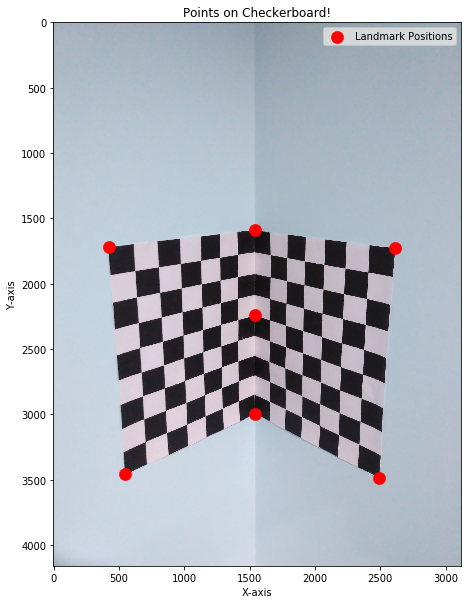

In [2]:
#List of point corresondences considered by me : 
mainImg=cv2.imread("C:\\Users\dell\\Desktop\\shmy_CV_1\\main.jpg")

Lc=[[424,1720],[1541,1591],[2616,1729],[2494,3487],[1542,2995],[549,3458],[1540,2244]]
#Based on the legend-world-calib image, we set the World cordinates accordingly .
x=[row[0] for row in Lc]
y=[row[1] for row in Lc]

# Display the checkboard points .
#Plot  
fig=plt.figure(figsize=(10,10))
plt.title('Points on Checkerboard!')
plt.style.use('ggplot')
plt.imshow(mainImg)
plt.scatter(x,y,marker='o',s=150,color='red',label='Landmark Positions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

In [3]:
# Data points used for computation DLT . 
## Printing out the corresponding world cordinates considered :
Lc=[[424,1720],[1541,1591],[2616,1729],[2494,3487],[1542,2995],[549,3458],[1540,2244]]
Lw=[[0,0,7,1],[0,0,0,1],[7,0,0,1],[7,9,0,1],[0,9,0,1],[0,9,7,1],[0,0,7,1]]
# Mapping of World Points to Image co-orinates.
L=zip(Lw,Lc)


### Helper Function for computing DLT 
 * computeRow(worldPoint,imgPoints) 
 - The world point (4x1) and image coordinate (3x1).
 - Output:Returns the row equation for the M matrix . 


In [4]:
def computeRow(Pc,Pw):
    row1=[-Pw[0],-Pw[1],-Pw[2],-1,0,0,0,0,Pc[0]*Pw[0],Pc[0]*Pw[1],Pc[0]*Pw[2],Pc[0]]
    row2=[0,0,0,0,-Pw[0],-Pw[1],-Pw[2],-1,Pc[1]*Pw[0],Pc[1]*Pw[1],Pc[1]*Pw[2],Pc[1]]
    return(np.vstack((row1,row2)))

#Testing the function .
A=computeRow([1,1],[1,1,1])
print(A)
print(A.shape)

[[-1 -1 -1 -1  0  0  0  0  1  1  1  1]
 [ 0  0  0  0 -1 -1 -1 -1  1  1  1  1]]
(2, 12)


### Main function : Direct Linear Transform . 

* Defination of parameters : 
  - The Lc is (2x1) vector, and Lw stands for World Cor-ordinates - (4X1) vector, with 1 appended at the end .
  - if verbose=True, all the values to be returned will be printed out .

In [5]:
def DLT(Lc,Lw,verbose=False):
    M=[]
    #Check if its less than 6 points. 
    if(len(Lc)<6 or (len(Lw)<6)):
        print("DLT cannot not be computed ! Need more than 6 points")
        return;
    I=np.asarray(Lc).shape[0]
    L=list(zip(Lc,Lw))
    #Creating point correspondance vector each row-col.
    for i in range(0,len(L)):
        M.append(computeRow(L[i][0],L[i][1]))
    M=np.reshape(np.asarray(M),(2*I,12))
    # Computing the SVD part .
    U, D, V_T =np.linalg.svd(M)
    #Extrating the last column of V
    P=np.reshape(V_T[-1,:],(3,4))
    
    # Calculating the Mean error now , as P is known to us . 
    # Take up all world co-ordinates ,mul by P , we know the corresponding image co-ordinates .
    # MSE between the vectors. 
    mse=0;
    for i in range(0,1,len(Lw)) : 
        xcPred=np.dot(P,np.reshape(np.asarray(Lw[i]),(4,1)));
        xcPred=xcPred[0:2]/xcPred[-1]
        mse=mse+np.linalg.norm((np.reshape(np.asarray(Lc[i]),(2,1))-xcPred))
    
    # Proceeding to find K,R sepeartingly.
    H_inf=P[0:3,0:3]
    H_inf_inv=np.linalg.pinv(H_inf)
    t_original=-1*np.dot(H_inf_inv,P[:,-1])
    #Q R Decomposition.
    q, r = np.linalg.qr(H_inf_inv)
    K=np.linalg.pinv(r)
    # The last corner elemt must be 1 .
    K=K*(1/K[2,2])
    R=np.dot(np.linalg.pinv(K),H_inf_inv)
    
    if(verbose):
        print("Reconstructed Camera Matrix (P):")
        print(P)
        print("Camera Calibration Matrix : ")
        print(K)
        print("Rotation Matrix :")
        print(R)
        print("Translation Vector (t) :")
        print(t_original)
        print("Mean Square Error is",mse)
        
    return(P,K,R,t_original,mse)


# Testing out the function : 
P,K,R,T,E=DLT(Lc,Lw,True)
    

Reconstructed Camera Matrix (P):
[[-1.72212123e-02 -2.35893816e-03 -7.36048323e-02  6.48086577e-01]
 [-5.90613670e-02  4.38088527e-02 -7.16087769e-02  7.50818585e-01]
 [-2.85608391e-05  1.66120829e-06 -3.54102053e-05  3.94971959e-04]]
Camera Calibration Matrix : 
[[ 7.17729058e+02 -1.24441656e+02  1.49312386e+03]
 [-3.49175798e-13  8.87577487e+02  2.07265701e+03]
 [-9.17325104e-16  4.41345146e-15  1.00000000e+00]]
Rotation Matrix :
[[ 4.77168965e+01  3.97867043e+00 -3.70479942e+04]
 [ 4.48056071e+01  3.75740289e+00 -3.47862407e+04]
 [-1.91868118e+01 -1.59705808e+00  1.48715726e+04]]
Translation Vector (t) :
[4.28515203 1.3227859  7.7599619 ]
Mean Square Error is 479.71819708601436


In [6]:
# Much Wider Dataset . 
Lcamadd=[[441,1934],[626,1902],[615,1699],[798,1674],[971,1656],[1133,1637],[1277,1622],[1407,1605]]
Lwadd=[[0,1,7,1],[0,1,6,1],[0,0,6,1],[0,0,5,1],[0,0,4,1],[0,0,3,1],[0,0,2,1],[0,0,1,1]]

Lc_test=[[798,1674],[971,1656],[1133,1637],[1277,1622],[1407,1605],[424,1720],[1541,1591],[2616,1729]]
Lw_test=[[0,0,5,1],[0,0,4,1],[0,0,3,1],[0,0,2,1],[0,0,1,1],[0,0,7,1],[0,0,0,1],[7,0,0,1]]


La=[[626,1902],[971,1656],[1277,1622],[1541,1590],[1661,1608],[2081,1662]];
Lb=[[0,1,6,1],[0,0,4,1],[0,0,2,1],[0,0,0,1],[1,0,0,1],[4,0,0,0]];

## DLT with RANSAC 

* Here, RANSAC allows us to choose the best model of P , byt picking out 6 points out of bunch of N points . 
* We can expect RANSAC based DLT will have less reprojection error. 

* Function documentation :
 - Input : N-World Points ,N-camera Points.
 - Output : Optimal Instrinsic Camera Matrix , Translation vector and Rotation Matrix . 


In [7]:
def dltwithRANSAC(Lcn,Lwn,verbose=False):
    # Randomly pick n points out of 6 .
    n=len(Lcn)
    msemax=10000;
    # Takes subset of 6 items in given n list. 
    for subset in itertools.combinations(range(0,n),6): 
        Lci=[Lcn[i] for i in subset]
        Lwi=[Lwn[i] for i in subset]
        # Calling DLT function .
        P,K,R,T,E=DLT(Lci,Lwi,False)
        if(E<msemax):
            Pf,Kf,Rf,Tf,mse=DLT(Lci,Lwi,verbose)
            msemax=mse
    return(Pf,Kf,Rf,Tf,msemax)

# Testing. 
A,B,C,D,E=dltwithRANSAC(La,Lb,verbose=True)
#ERROR has dropped down to 0.25 ( compared to 479.1)

Reconstructed Camera Matrix (P):
[[ 4.25919083e-13  3.12629714e-01 -8.27338992e-13  6.99425671e-12]
 [-1.51443422e-13  9.49874946e-01 -2.28704146e-13  7.23689630e-12]
 [-1.82212955e-16  4.99408489e-04 -2.07870593e-16  4.55820531e-15]]
Camera Calibration Matrix : 
[[ 1.70828202e+02  6.00122309e+13  6.26000001e+02]
 [-1.91226648e-06  1.82337481e+14  1.90200000e+03]
 [ 3.68694448e-03  9.58661833e+10  1.00000000e+00]]
Rotation Matrix :
[[ 3.51749577e+09 -1.15770338e+09 -5.24535840e+05]
 [-2.70123099e-06  8.89048480e-07  4.02812844e-10]
 [-2.81770996e-17  9.27384870e-18  4.20182415e-21]]
Translation Vector (t) :
[-2.77087840e+00 -7.00595812e-12  4.38008614e+00]
Mean Square Error is 1.520856267979129e-11


#  Radial Distortion Correction 

* We use special type of correction methods ,where we have intial estimates of the camera's calibration matrix .
* Another option , we can assume that same camera was used in Zhang's process , and use its parameters to estimate error here . 


In [8]:
#Defining the image to be taken . 
I=cv2.imread('C:\\Users\\dell\\Desktop\\shmy_CV_1\\Fig1.png');
gray=cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
intialK=np.asarray([[ 7.17729058e+02,-1.24441656e+02,1.49312386e+03],
 [-3.49175798e-13,8.87577487e+02 , 2.07265701e+03],[-9.17325104e-16 , 4.41345146e-15 , 1.00000000e+00]])

#intialK=np.asarray([[1.70828202e+02,6.00122309e+13,6.26000001e+02],[-1.91226648e-06,1.82337481e+14,1.90200000e+03],[ 3.68694448e-03,9.58661833e+10,1.00000000e+00]])
print(intialK)


[[ 7.17729058e+02 -1.24441656e+02  1.49312386e+03]
 [-3.49175798e-13  8.87577487e+02  2.07265701e+03]
 [-9.17325104e-16  4.41345146e-15  1.00000000e+00]]


In [9]:
La=[[626,1902,1],[971,1656,1],[1277,1622,1],[1541,1590,1],[1661,1608,1],[2081,1662,1]];
Lb=[[0,1,6,1],[0,0,4,1],[0,0,2,1],[0,0,0,1],[1,0,0,1],[4,0,0,0]];

In [10]:
# checkerboard Dimensions
cbrow = 7
cbcol = 7

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((cbrow * cbcol, 3), np.float32)
objp[:, :2] = np.mgrid[0:cbcol, 0:cbrow].T.reshape(-1, 2)

ret, corners = cv2.findChessboardCorners(gray, (cbcol, cbrow), None)
    
    


(1233, 1918, 3)
[[  71.7  165.4]
 [  84.7  366.6]
 [  97.2  563.4]
 [ 108.3  754.1]
 [ 119.7  940.9]
 [ 130.5 1122.5]
 [ 251.3  137. ]
 [ 261.6  331.1]
 [ 272.9  520.6]
 [ 282.1  705.6]
 [ 290.9  886.8]
 [ 298.2 1062.6]
 [ 419.3  110.6]
 [ 425.6  297.8]
 [ 432.8  480.5]]


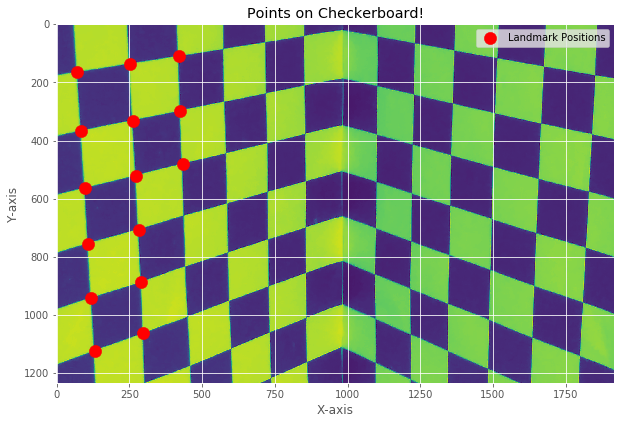

In [15]:
I=cv2.imread('C:\\Users\\dell\\Desktop\\shmy_CV_1\\Fig1.png');
gray=cv2.cvtColor(I, cv2.COLOR_BGR2GRAY);

print(I.shape)
imgPoints=1000*np.asarray([[0.0717,0.1654]
    ,[0.0847,0.3666]
    ,[0.0972 ,0.5634]
    ,[0.1083, 0.7541]
    ,[0.1197,0.9409]
    ,[0.1305,1.1225]
    ,[0.2513,0.1370]
    ,[0.2616,0.3311]
    ,[0.2729,0.5206]
    ,[0.2821,0.7056]
    ,[0.2909,0.8868]
    ,[0.2982,1.0626]
    ,[0.4193,0.1106]
    ,[0.4256,0.2978]
    ,[0.4328,0.4805]])
worldPoints=[[0,0,0],[0,1,0],[0,2,0],[0,3,0],[0,4,0],[0,5,0],[1,0,0],[1,1,0],[1,2,0],[1,3,0],[1,4,0],[1,5,0],[2,0,0],[2,1,0],[2,2,0]]
worldPoints=np.asarray(worldPoints)

worldPoints1=[[0,0,0,1],[0,1,0,1],[0,2,0,1],[0,3,0,1],[0,4,0,1],[0,5,0,1],[1,0,0,1],[1,1,0,1],[1,2,0,1],[1,3,0,1],[1,4,0,1],[1,5,0,1],[2,0,0,1],[2,1,0,1],[2,2,0,1]]
worldPoints1=np.asarray(worldPoints1)

print(imgPoints)

x=[row[0] for row in imgPoints]
y=[row[1] for row in imgPoints]

# Display the checkboard points .
#Plot  
fig=plt.figure(figsize=(10,10))
plt.title('Points on Checkerboard!')
plt.style.use('ggplot')
plt.imshow(gray)
plt.scatter(x,y,marker='o',s=150,color='red',label='Landmark Positions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


In [12]:
def estimate_and_undistort(img,K, world_coords, img_coords):
    obj_points = [np.array(world_coords,dtype=np.float32)]
    img_points = [np.array([img_coords[i] for i in range(img_coords.shape[0])],dtype=np.float32)]
    camera_matrix = K
    camera_matrix[0,1]=0
    dist_coefs = np.zeros(4)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points,img_points, gray.shape[::-1],camera_matrix,dist_coefs, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    undistorted_img = cv2.undistort(img, mtx, dist, None, newcameramtx)
    cv2.imwrite('calib-undistort.png', undistorted_img)
    return dist, undistorted_img, newcameramtx

In [13]:
#d,Id,P=estimate_and_undistort(I,Kprime,worldPoints,imgPoints)
print("Output Image is :")

Output Image is :


<img src="undist.jpg" width="500">

In [19]:
# Applying DLT on this img .
Icorr=cv2.imread('C:\\Users\\dell\\Desktop\\shmy_CV_1\\undist.jpg')
La1=[[626,1902],[971,1656],[1277,1622],[1541,1590],[1661,1608],[2081,1662]];
Lb1=[[0,1,6,1],[0,0,4,1],[0,0,2,1],[0,0,0,1],[1,0,0,1],[4,0,0,0]];

P,K,R,T,E=DLT(La1,Lb1,True)

Reconstructed Camera Matrix (P):
[[ 4.25919083e-13  3.12629714e-01 -8.27338992e-13  6.99425671e-12]
 [-1.51443422e-13  9.49874946e-01 -2.28704146e-13  7.23689630e-12]
 [-1.82212955e-16  4.99408489e-04 -2.07870593e-16  4.55820531e-15]]
Camera Calibration Matrix : 
[[ 1.70828202e+02  6.00122309e+13  6.26000001e+02]
 [-1.91226648e-06  1.82337481e+14  1.90200000e+03]
 [ 3.68694448e-03  9.58661833e+10  1.00000000e+00]]
Rotation Matrix :
[[ 3.51749577e+09 -1.15770338e+09 -5.24535840e+05]
 [-2.70123099e-06  8.89048480e-07  4.02812844e-10]
 [-2.81770996e-17  9.27384870e-18  4.20182415e-21]]
Translation Vector (t) :
[-2.77087840e+00 -7.00595812e-12  4.38008614e+00]
Mean Square Error is 1.520856267979129e-11


# Own Setup : DLT 

In [ ]:
# Data reading .
camPic=cv2.imread("C:\\Users\\dell\\Desktop\\shmy_CV_1\\rubrik.jpg")
[M,N,P]=camPic.shape
rImg = cv2.resize(camPic,(1024,1024), interpolation = cv2.INTER_AREA)
[M1,N1,P1]=rImg.shape
cv2.imwrite("final.jpg",rImg)

print((M1,N1,P1))
plt.imshow(rImg)

x=[row[0] for row in Lc]
y=[row[1] for row in Lc]
print(x)
print(y)


In [ ]:
# We applpy DLT method for this .
Pcam=[[122,342],[522,534],[213,569],[510,739],[726,537],[830,329],[484,328],[464,184]]
Pworld=[[3,0,0,1],[0,0,0,1],[3,0,3,1],[0,0,3,1],[0,3,3,1],[0,3,0,1],[1.5,1.5,0,1],[3,3,0,1]]


x=[row[0] for row in Pcam]
y=[row[1] for row in Pcam]
print(x)
print(y)

# Display the checkboard points .
#Plot  
fig=plt.figure(figsize=(7,7))
plt.title('Points on Rubrik Cube!')
plt.style.use('ggplot')
plt.imshow(rImg)
plt.scatter(x,y,marker='o',s=120,color='yellow',label='Landmark Positions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


In [ ]:
# Calling DLT function .
_,_,_,_,_=DLT(Pcam[0:6],Pworld[0:6],verbose=True)


# Visualising Origin Image 

* The world origin when multiplied by the camera matrix gets projected onto the corresponding
  location in the image as expected. 

In [ ]:
P,K,R,T,E=DLT(Lc,Lw,True)

In [ ]:
P=np.asarray([[-1.72212123e-02,-2.35893816e-03, -7.36048323e-02 , 6.48086577e-01]
 ,[-5.90613670e-02 , 4.38088527e-02, -7.16087769e-02 , 7.50818585e-01]
 ,[-2.85608391e-05 , 1.66120829e-06 ,-3.54102053e-05 , 3.94971959e-04]])

In [ ]:
imgOrigin=np.dot(P,np.asarray([0,0,0,1]));

imgarr=cv2.imread("C:\\Users\dell\\Desktop\\shmy_CV_1\\main.jpg")


fig=plt.figure(figsize=(10,10))
plt.title('Origin of Checkerboard!')
plt.style.use('ggplot')
plt.imshow(imgarr)
plt.scatter(imgOrigin[0],imgOrigin[1],marker='o',s=120,color='red',label='Origin Position')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()